In [ ]:
from simple_unet import multi_unet_model
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import sys
import random

np.set_printoptions(threshold=sys.maxsize)

: 

In [39]:
#Resizing images
SIZE_X = 640
SIZE_Y = 640
n_classes= 9 # Number of classes for segmentation

TRAIN_PATH_X = '/home/khamituly/Documents/Diploma work/dataset_manual/temp_health/X'
TRAIN_PATH_Y = '/home/khamituly/Documents/Diploma work/dataset_manual/temp_health/Y_test'

train_ids_x = next(os.walk(TRAIN_PATH_X))[2]
train_ids_y = next(os.walk(TRAIN_PATH_Y))[2]

In [40]:
#Capture training image info as a list
train_images = []

for directory_path in glob.glob(TRAIN_PATH_X):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)    

#Convert list to array for machine learning processing        
train_images = np.array(train_images)

In [41]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob(TRAIN_PATH_Y):
    for mask_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [42]:
np.unique(train_masks)

array([  0,  16,  24,  41,  74, 106, 139, 180, 255], dtype=uint8)

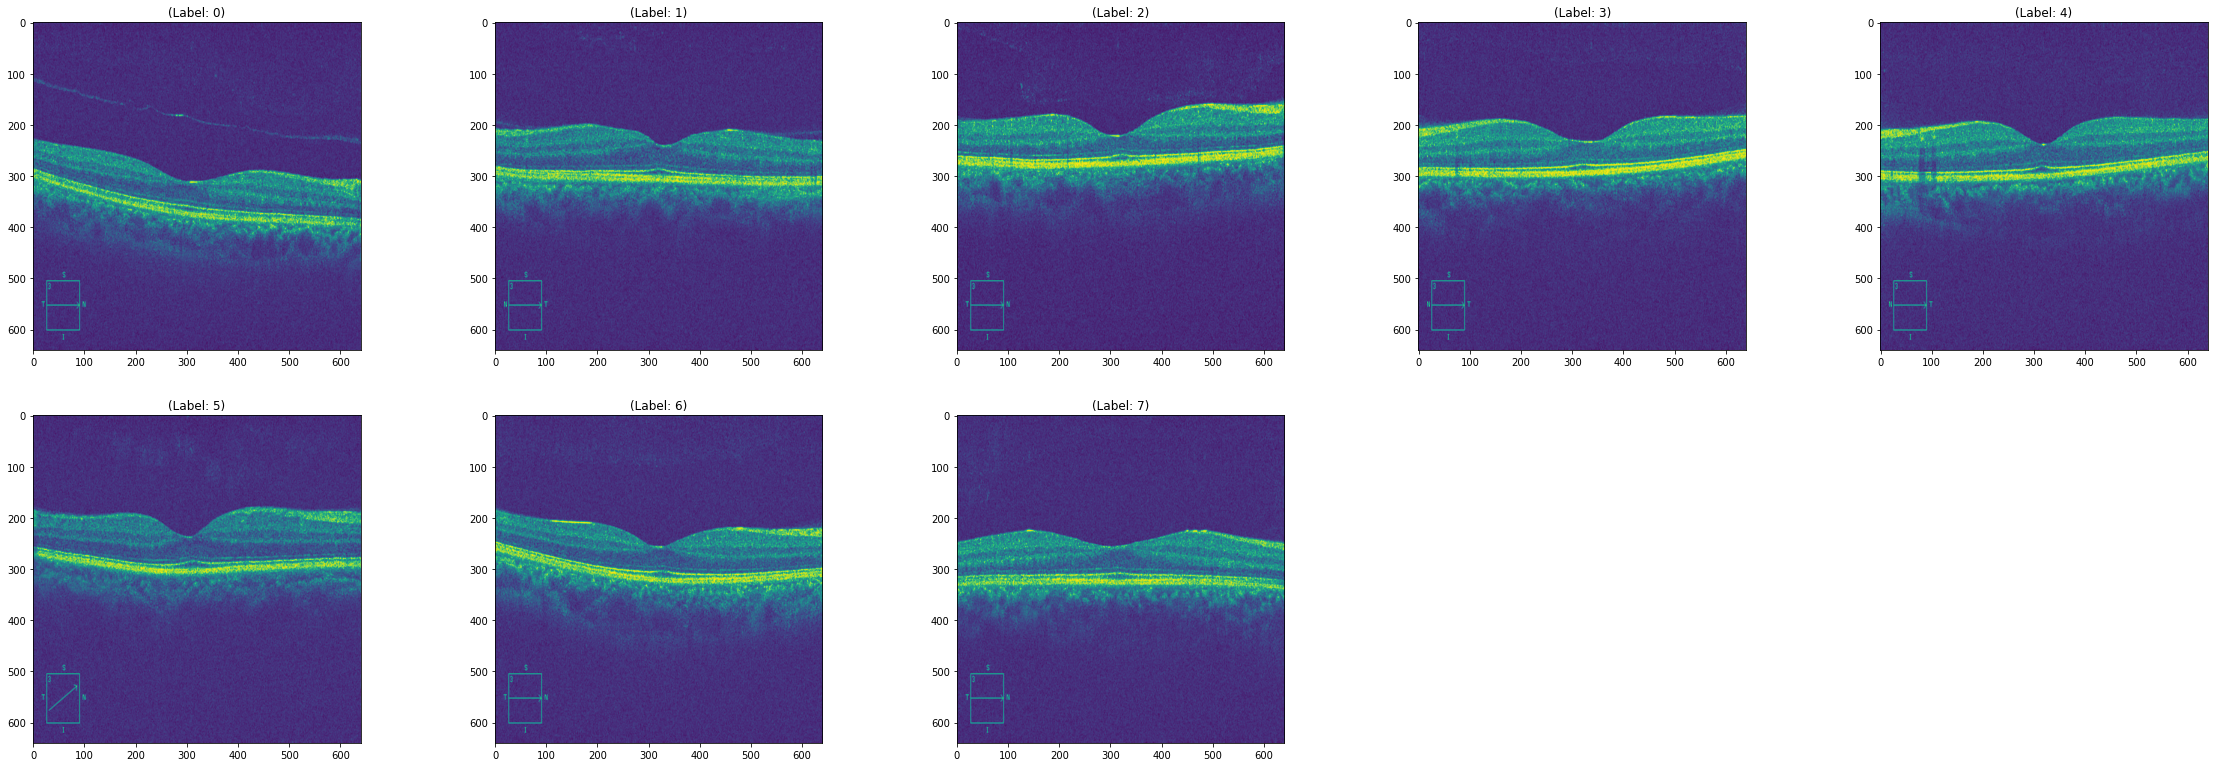

In [46]:
plt.figure(figsize=(40,100))
for i in range(8):
    plt.subplot(14, 5, i+1)
    plt.imshow(train_images[i,:,:])
    plt.title("(Label: " + str(i) + ")")
plt.show()   

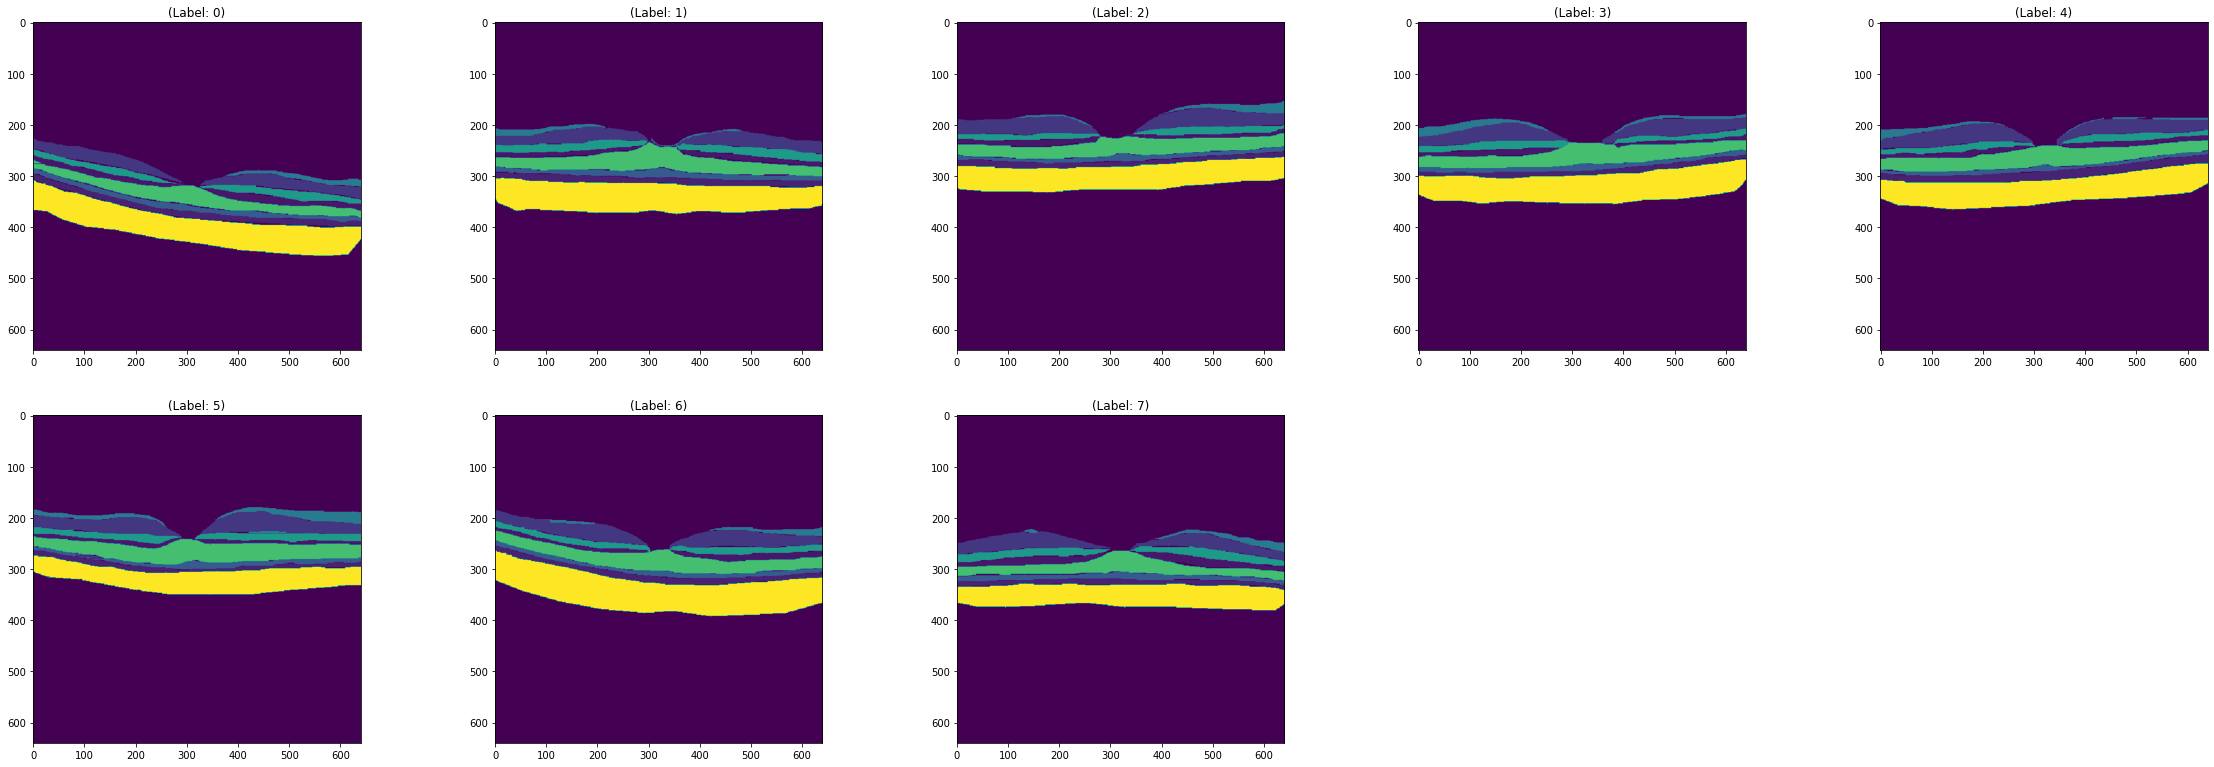

In [47]:
plt.figure(figsize=(40,100))
for i in range(8):
    plt.subplot(14, 5, i+1)
    plt.imshow(train_masks[i,:,:])
    plt.title("(Label: " + str(i) + ")")
plt.show()   

In [48]:
#Encode labels
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)


In [49]:

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 


Class values in the dataset are ...  [0 1 2 3 4 5 6 7 8]


In [50]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [52]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=SIZE_Y, IMG_WIDTH=SIZE_X, IMG_CHANNELS=1)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 640, 640, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 640, 640, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 640, 640, 16) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 640, 640, 16) 2320        dropout_9[0][0]                  
____________________________________________________________________________________________

In [73]:

#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=200, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)
                    

_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

Epoch 1/20
1/1 [==============================] - 8s 8s/step - loss: 0.0904 - accuracy: 0.9707 - val_loss: 0.1023 - val_accuracy: 0.9644
Epoch 2/20
1/1 [==============================] - 8s 8s/step - loss: 0.0879 - accuracy: 0.9717 - val_loss: 0.0972 - val_accuracy: 0.9679
Epoch 3/20
1/1 [==============================] - 8s 8s/step - loss: 0.0884 - accuracy: 0.9716 - val_loss: 0.1009 - val_accuracy: 0.9666
Epoch 4/20
1/1 [==============================] - 7s 7s/step - loss: 0.0861 - accuracy: 0.9721 - val_loss: 0.1112 - val_accuracy: 0.9615
Epoch 5/20
1/1 [==============================] - 7s 7s/step - loss: 0.0867 - accuracy: 0.9717 - val_loss: 0.1102 - val_accuracy: 0.9614
Epoch 6/20
1/1 [==============================] - 7s 7s/step - loss: 0.0848 - accuracy: 0.9722 - val_loss: 0.1018 - val_accuracy: 0.9649
Epoch 7/20
1/1 [==============================] - 7s 7s/step - loss: 0.0835 - accuracy: 0.9730 - val_loss: 0.0954 - val_accuracy: 0.9679
Epoch 8/20
1/1 [=========================

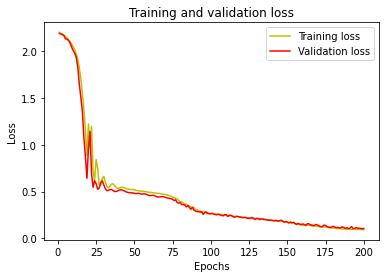

In [54]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

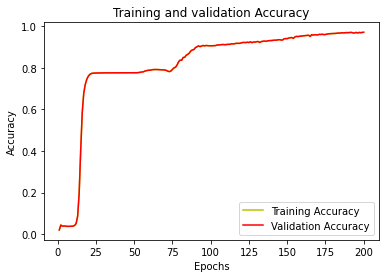

In [56]:

acc = history.history['accuracy']
val_acc = history.history['accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [57]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

In [58]:
#Using built in keras function
from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


Mean IoU = 0.75462574


In [ ]:
## This is example of IOU of 4 class, if you need provide corresponding amount of class 

values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])


print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

In [92]:
# You can save your trained model by uncommenting below line

# model.save('retina_segmentation_8_layer_iter_3+20epochs.hdf5')

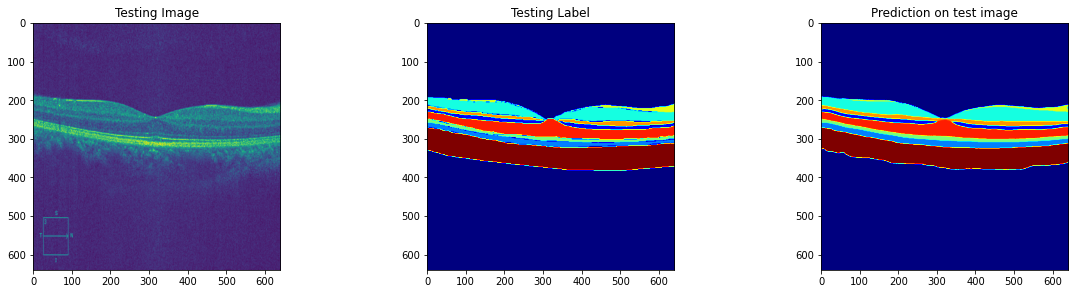

In [74]:
test_img_number = 5
test_img = X_train[test_img_number]
ground_truth= y_train[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)

prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [62]:
#Capture training image info as a list
test_test = []

test_path = "/home/khamituly/Documents/Diploma work/big_datasets/manual_segm/"

for directory_path in glob.glob(test_path):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        test_test.append(img)
        print(img_path)    

#Convert list to array for machine learning processing        
test_test = np.array(test_test)

test_test = np.expand_dims(test_test, axis=3)
test_test = normalize(test_test, axis=1)

/home/khamituly/Documents/Diploma work/big_datasets/manual_segm/26 OD - Copy.jpeg
/home/khamituly/Documents/Diploma work/big_datasets/manual_segm/2 macula - Copy.jpeg
/home/khamituly/Documents/Diploma work/big_datasets/manual_segm/34 OS - Copy.jpeg
/home/khamituly/Documents/Diploma work/big_datasets/manual_segm/22 OD - Copy.jpeg
/home/khamituly/Documents/Diploma work/big_datasets/manual_segm/06 OS - Copy.jpeg
/home/khamituly/Documents/Diploma work/big_datasets/manual_segm/14 OS - Copy.jpeg
/home/khamituly/Documents/Diploma work/big_datasets/manual_segm/56 OS - Copy.jpeg
/home/khamituly/Documents/Diploma work/big_datasets/manual_segm/108 OD - Copy.jpeg
/home/khamituly/Documents/Diploma work/big_datasets/manual_segm/182 OS - Copy.jpeg
/home/khamituly/Documents/Diploma work/big_datasets/manual_segm/9 macula - Copy.jpeg
/home/khamituly/Documents/Diploma work/big_datasets/manual_segm/33 OD - Copy.jpeg
/home/khamituly/Documents/Diploma work/big_datasets/manual_segm/31 OD - Copy.jpeg
/home/kh

In [63]:
test_test.shape

(25, 640, 640, 1)

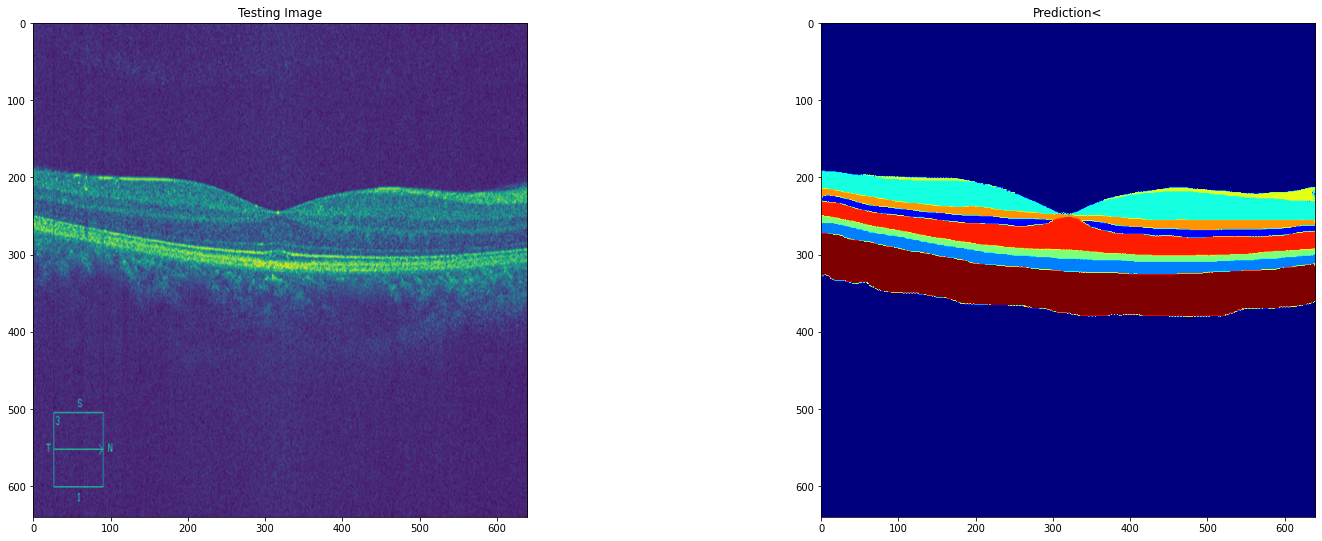

In [91]:
test1 = test_test[12]
test_img_norm=test1[:,:,0][:,:,None]
test=np.expand_dims(test_img_norm, 0)

prediction = (model.predict(test))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(40, 20))

plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test1[:,:,0])

plt.subplot(232)
plt.title('Prediction<')
# plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.imshow(predicted_img, cmap='jet')

# plt.imshow(prediction[0,:,:,7], cmap='jet')


In [65]:
prediction.shape

(1, 640, 640, 9)

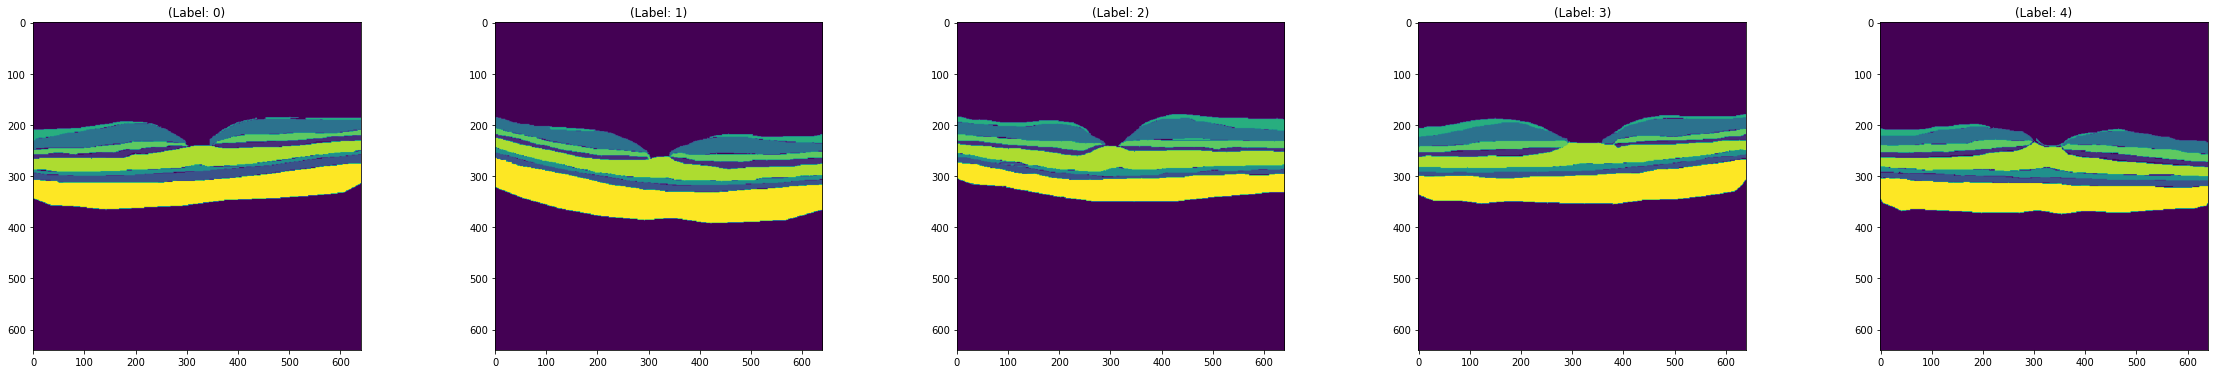

In [66]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(5):
    plt.subplot(14, 5, i+1)
    plt.imshow(y_train[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()   

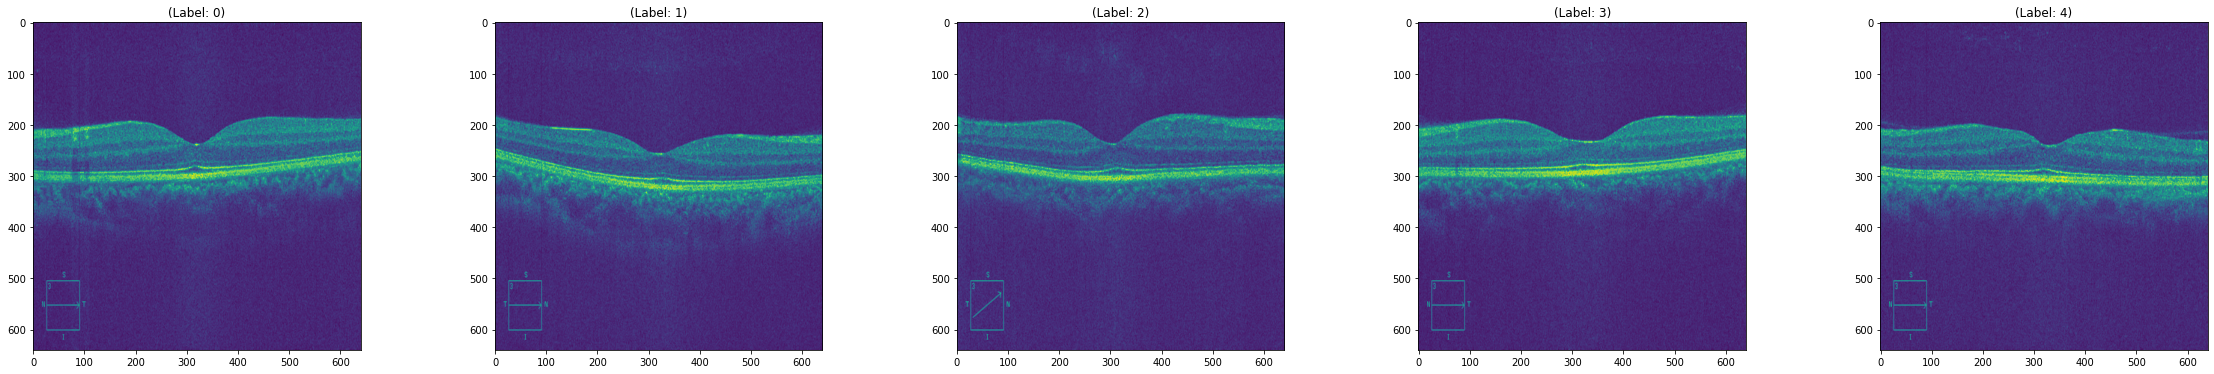

In [67]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(5):
    plt.subplot(14, 5, i+1)
    plt.imshow(X_train[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()   

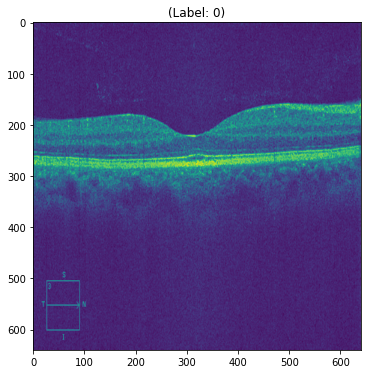

In [68]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(1):
    plt.subplot(14, 5, i+1)
    plt.imshow(X_test[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()   

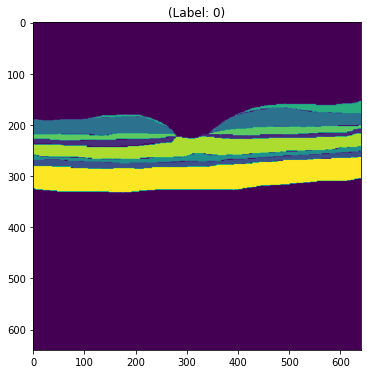

In [69]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(1):
    plt.subplot(14, 5, i+1)
    plt.imshow(y_test[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()   